# **Baseline Models with BagofWords Vectorization**
# **CIS 5190 Group Project**
By 	Mona Gandhi, Jeffrey Li, Henil Satra <br>

# Imports/Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns


# preprocessing
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# classification
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk
From (redirected): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk&confirm=t&uuid=4f815e1d-11bc-48b4-a149-155e7ca169b1
To: /content/Reviews.csv
100% 301M/301M [00:05<00:00, 58.7MB/s]


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Loading


In [ ]:
reviews_df = pd.read_csv('Reviews.csv')

In [ ]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Data Preparation

In [ ]:
reviews_df = reviews_df[['Text', 'Score']]

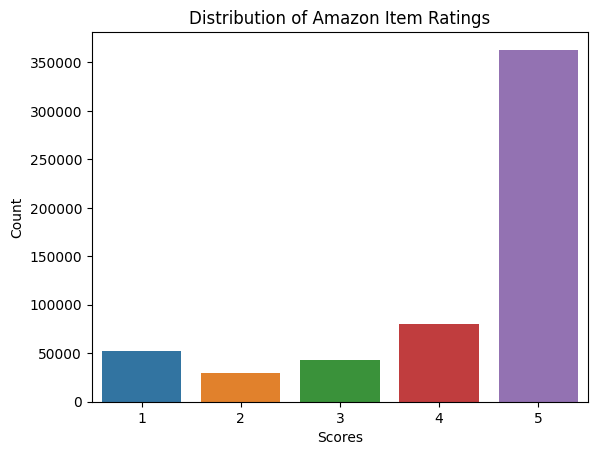

In [ ]:
sns.countplot(x=reviews_df.Score)
plt.xlabel('Scores')
plt.ylabel("Count")
plt.title("Distribution of Amazon Item Ratings")
plt.show()

In [ ]:
# create labels: "Positive" and "Negative"
reviews_df['Label'] = reviews_df['Score'].apply(lambda x: "Positive" if x > 3 else "Negative")

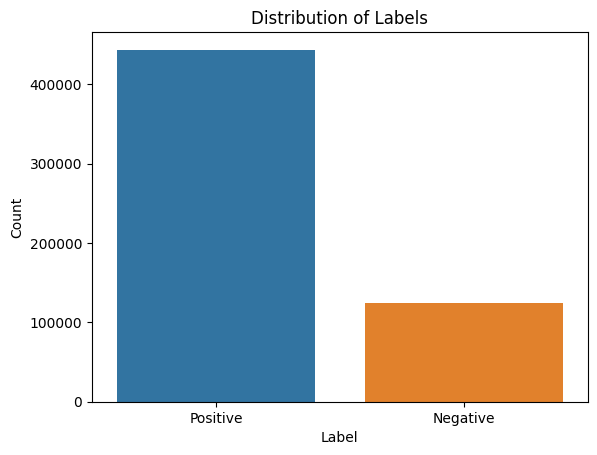

In [ ]:
sns.countplot(x=reviews_df.Label)
plt.xlabel('Label')
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# Data Preprocessing

In [ ]:
reviews_df = reviews_df[reviews_df['Text'].notna()]

In [ ]:
reviews_df = reviews_df[reviews_df['Text'].apply(lambda x: len(x.split()) != 0)]

In [ ]:
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

reviews_df['Text'] = reviews_df['Text'].apply(clean_text)

In [ ]:
reviews_df.head()

,Text,Score,Label
0,bought several vitality canned dog food produc...,5,Positive
1,product arrived labeled jumbo salted peanutsth...,1,Negative
2,confection around centuries light pillowy citr...,4,Positive
3,looking secret ingredient robitussin believe f...,2,Negative
4,great taffy great price wide assortment yummy ...,5,Positive


In [ ]:
reviews_df.shape

(568454, 3)

## Train-Test Split

In [ ]:
X = reviews_df['Text']

In [ ]:
y = np.where(reviews_df['Label']=='Positive', 1, 0)

In [ ]:
# train test split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow = CountVectorizer()
bow.fit(X_train)
X_train = bow.transform(X_train)
X_test = bow.transform(X_test)
bow_features = bow.get_feature_names_out()

print(f'shape of X_train_bow is {X_train.get_shape()}')
print(f'shape of X_test_bow is {X_test.get_shape()}')

shape of X_train_bow is (454763, 189295)
shape of X_test_bow is (113691, 189295)


In [ ]:
X_train

<454763x189295 sparse matrix of type '<class 'numpy.int64'>'
	with 15862741 stored elements in Compressed Sparse Row format>

In [ ]:
type(X_train[0][0])

scipy.sparse._csr.csr_matrix

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(454763, 189295)
(113691, 189295)
(454763,)
(113691,)


## Random Undersampling

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under= rus.fit_resample(X_train_copy, y_train_copy)

In [ ]:
print('Undersampled X dimensions: ', X_train_under.shape)
print('Undersampled y dimensions: ', y_train_under.shape)

Undersampled X dimensions:  (200022, 189295)
Undersampled y dimensions:  (200022,)


In [ ]:
import collections
collections.Counter(y_train_under)

Counter({0: 100011, 1: 100011})

# Baseline Classification Models

## Experiment: Undersampling

### Naive Bayes

In [ ]:
# naive bayes fit and predict
nb_clf_under = BernoulliNB().fit(X_train_under, y_train_under) 
y_pred = nb_clf_under.predict(X_test)

In [ ]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.8358005470969558

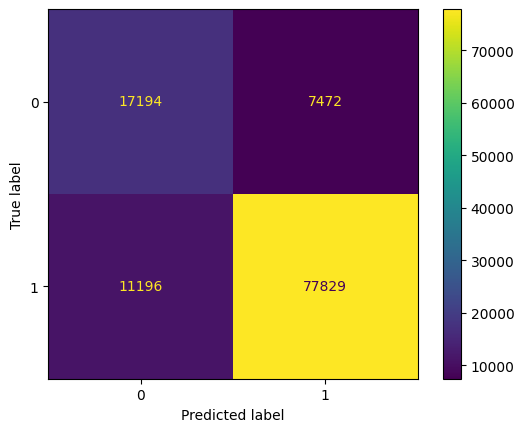

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17194
False Positive:  7472
False Negative:  11196
True Positive:  77829


In [ ]:
y_test

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
y_pred

array([1, 1, 1, ..., 0, 0, 1])

ROC Area Under the Curve:  0.7856552337886226


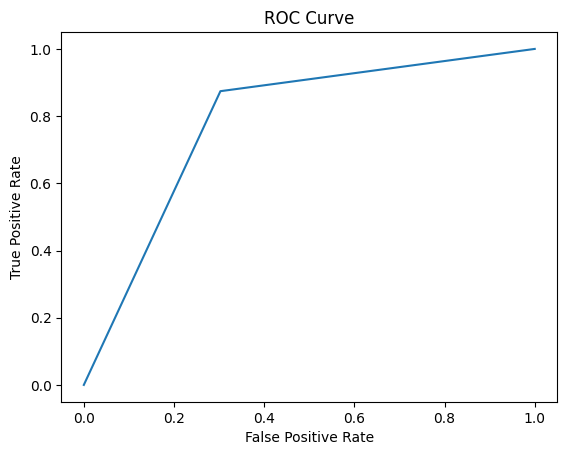

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8929132774227596


#### Hyperparameter Tuning

In [ ]:
nb_clf_under = BernoulliNB()
nb_clf_under.get_params()

{'alpha': 1.0,
 'binarize': 0.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': 'warn'}

In [ ]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
nb_clf_under = GridSearchCV(nb_clf_under, param, n_jobs=-1, cv=cv)
result = nb_clf_under.fit(X_train_under, y_train_under)
y_pred = nb_clf_under.predict(X_test)

In [ ]:
print("best hyperparameters: ", nb_clf_under.best_params_)

best hyperparameters:  {'alpha': 0.1, 'fit_prior': False}


In [ ]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.8394507920591779

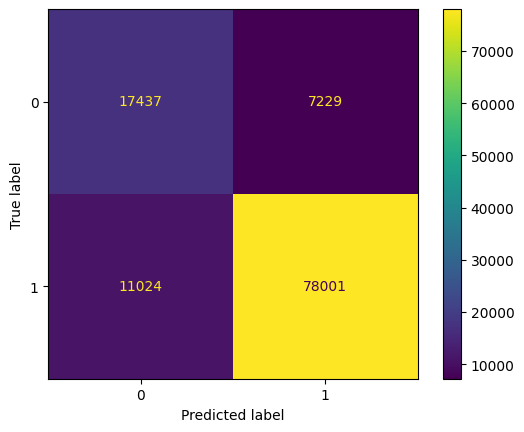

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17437
False Positive:  7229
False Negative:  11024
True Positive:  78001


ROC Area Under the Curve:  0.7915470633749455


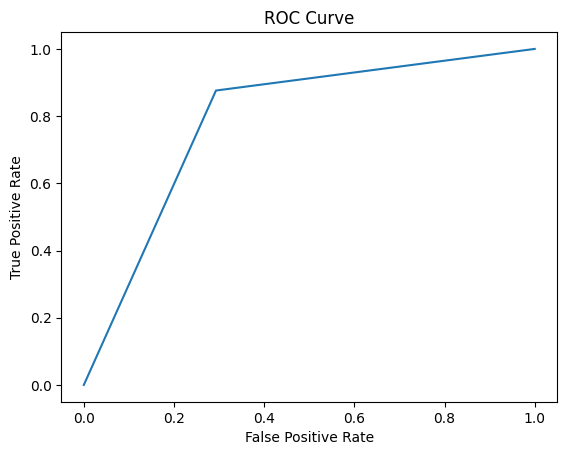

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8952512123038077


###  Logistic Regression

In [ ]:
# logistic regression fit and predict
lr_clf_under = LogisticRegression().fit(X_train_under, y_train_under) 
y_pred = lr_clf_under.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# model accuracy
log_acc = accuracy_score(y_test, y_pred)
log_acc

0.8709836310701815

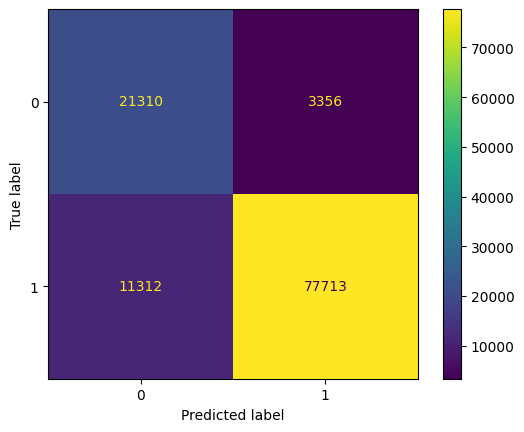

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  21310
False Positive:  3356
False Negative:  11312
True Positive:  77713


ROC Area Under the Curve:  0.8684384188256369


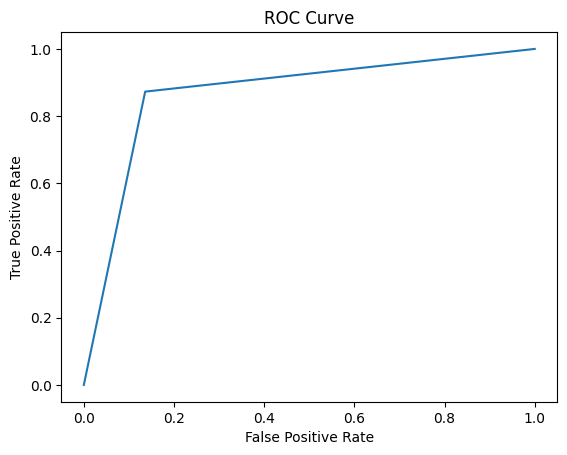

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.9137653297588393


#### Hyperparameter Tuning

In [ ]:
lr_clf_under = LogisticRegression()
lr_clf_under.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2']
}
lr_clf_under = GridSearchCV(lr_clf_under, param, n_jobs=-1, cv=cv)
result = lr_clf_under.fit(X_train_under, y_train_under)
y_pred = lr_clf_under.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver l

In [ ]:
print("best hyperparameters: ", lr_clf_under.best_params_)

best hyperparameters:  {'C': 1, 'penalty': 'l2'}


In [ ]:
# model accuracy
lr_acc = accuracy_score(y_test, y_pred)
lr_acc

0.8709836310701815

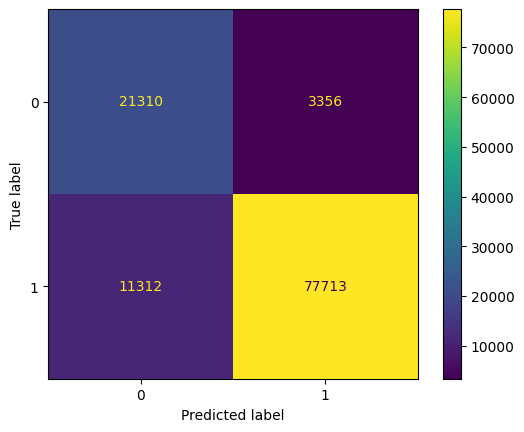

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  21310
False Positive:  3356
False Negative:  11312
True Positive:  77713


ROC Area Under the Curve:  0.8684384188256369


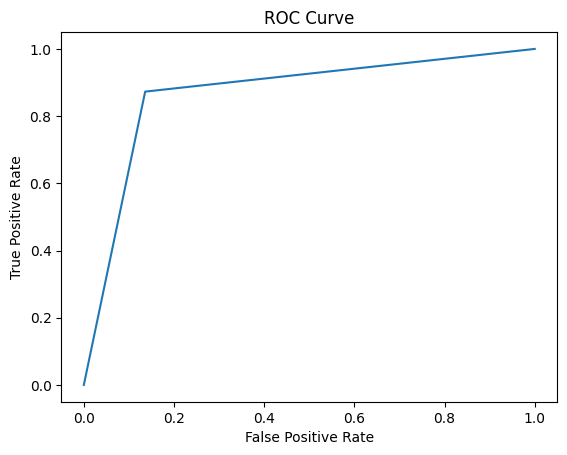

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.9137653297588393


###  XGBoost

In [ ]:
# xgboost fit and predict
xgb_clf_under = xgb.XGBClassifier().fit(X_train_under, y_train_under) 
y_pred = xgb_clf_under.predict(X_test)

In [ ]:
# model accuracy
xgb_acc = accuracy_score(y_test, y_pred)
xgb_acc

0.8291245569130362

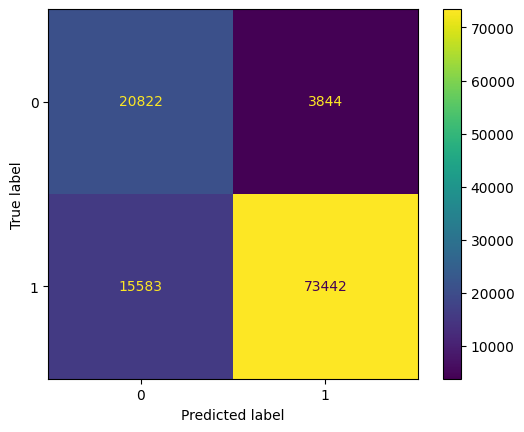

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  20822
False Positive:  3844
False Negative:  15583
True Positive:  73442


ROC Area Under the Curve:  0.8345586156578424


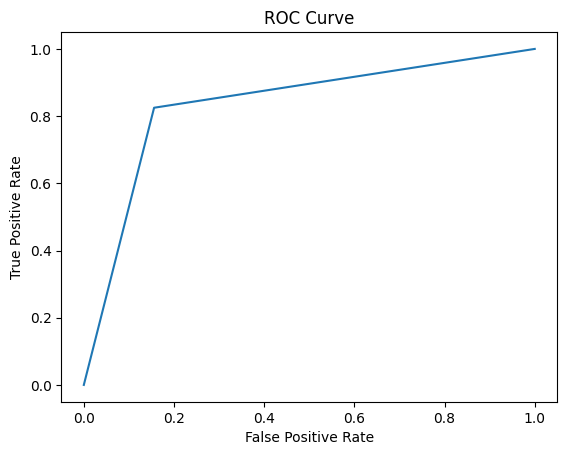

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8831887247385921


# Dataset Shift

In [ ]:
if not os.path.exists("/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv"):
  !gdown 1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp

In [ ]:
movies_df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv')

In [ ]:
movies_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


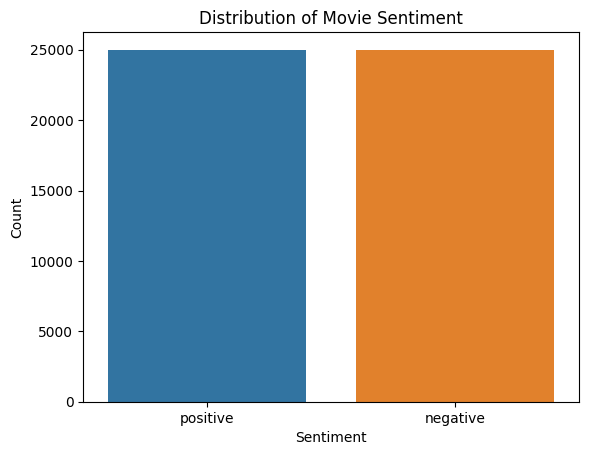

In [ ]:
sns.countplot(x=movies_df.sentiment)
plt.xlabel('Sentiment')
plt.ylabel("Count")
plt.title("Distribution of Movie Sentiment")
plt.show()

## Preprocessing

In [ ]:
movies_df = movies_df[movies_df['review'].notna()]
movies_df = movies_df[movies_df['review'].apply(lambda x: len(x.split()) != 0)]
movies_df['review'] = movies_df['review'].apply(clean_text)

In [ ]:
movies_df.shape

(50000, 2)

In [ ]:
movies_df

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


In [ ]:
X = bow.transform(movies_df['review'])
print('Shape of data tensor:', X.shape)

Shape of data tensor: (50000, 189295)


In [ ]:
y = np.where(movies_df['sentiment']=='positive', 1, 0)
print('Shape of label tensor:', y.shape)

Shape of label tensor: (50000,)


## Testing the models on the entire dataset


### Naive Bayes

In [ ]:
# naive bayes predict
y_pred = nb_clf_under.predict(X)
# model accuracy
nb_acc = accuracy_score(y, y_pred)
print("Accuracy for Naive Bayes: ", nb_acc)

Accuracy for Naive Bayes:  0.67006


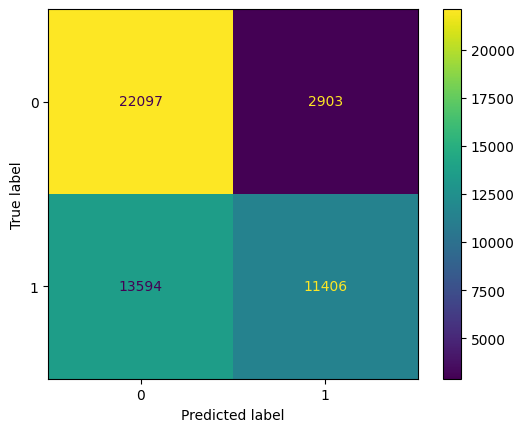

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  22097
False Positive:  2903
False Negative:  13594
True Positive:  11406


ROC Area Under the Curve:  0.67006


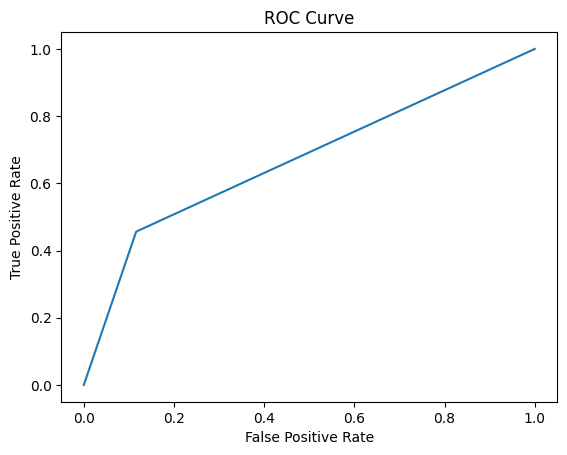

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.5803251163855606


### Logistic Regression

In [ ]:
# logistic regression predict
y_pred = lr_clf_under.predict(X)
# model accuracy
lr_acc = accuracy_score(y, y_pred)
print("Accuracy for Logistic Regression: ", lr_acc)

Accuracy for Logistic Regression:  0.7563


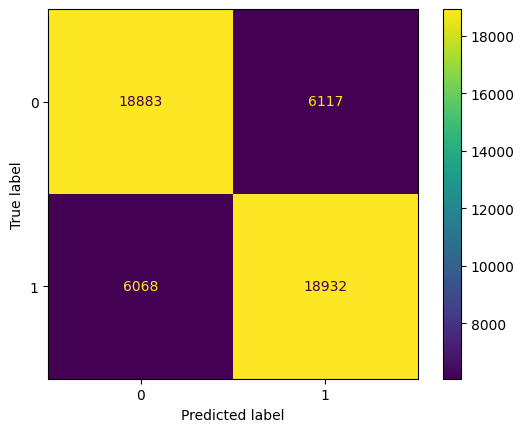

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  18883
False Positive:  6117
False Negative:  6068
True Positive:  18932


ROC Area Under the Curve:  0.7563


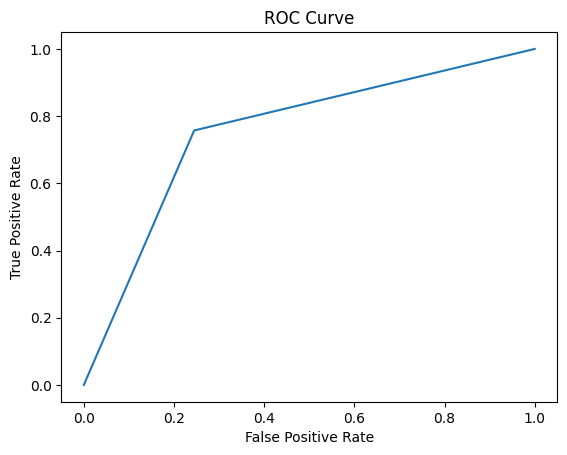

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.7565385921796639


### XGBoost

In [ ]:
# xgboost predict
y_pred = xgb_clf_under.predict(X)
# model accuracy
xgb_acc = accuracy_score(y, y_pred)
print("Accuracy for XGBoost: ", xgb_acc)

Accuracy for XGBoost:  0.75674


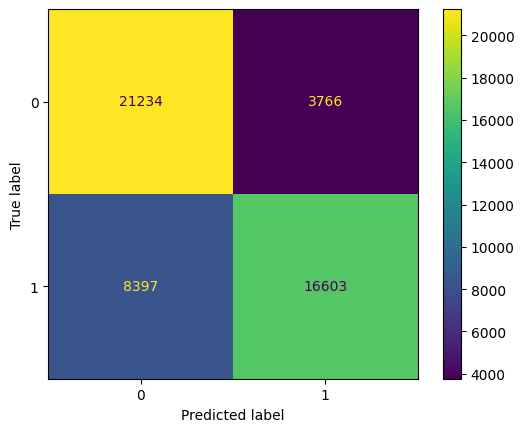

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  21234
False Positive:  3766
False Negative:  8397
True Positive:  16603


ROC Area Under the Curve:  0.7567400000000001


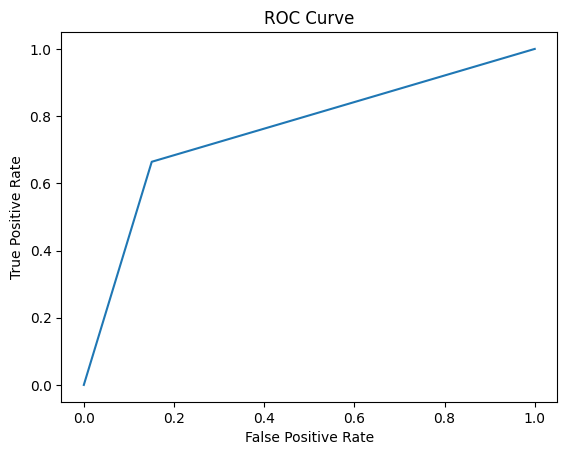

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.7319094535916595


# Save Models

In [ ]:
# import os
# import joblib

In [ ]:
# path = "/content/drive/MyDrive/CIS5190-Project/Work/Models"

In [ ]:
# filename = "nb_model.pkl"
# if not os.path.exists(path):
#     os.makedirs(path)
# joblib.dump(nb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/nb_model.pkl']

In [ ]:
# filename = "lr_model.pkl"
# if not os.path.exists(path):
#     os.makedirs(path)
# joblib.dump(lr_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/lr_model.pkl']

In [ ]:
# filename = "xgb_model.pkl"
# if not os.path.exists(path):
#     os.makedirs(path)
# joblib.dump(xgb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/xgb_model.pkl']